In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+100+1000, num_feat, grid, deg, e, seed=42)

In [3]:
from pyepo.model.grb import shortestPathModel
# set solver
optmodel = shortestPathModel(grid)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
for i, e in enumerate(optmodel.arcs):
    if sol[i] > 1e-3:
        print(e)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 3.6258033206091707
(0, 1)
(1, 6)
(6, 7)
(7, 12)
(12, 17)
(17, 18)
(18, 19)
(19, 24)


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 675.39it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 663.96it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 630.30it/s]


In [6]:
# get training and test data set without costs
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols)

Obtaining constraints for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 530.77it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 1e-2
num_epochs = 20
log_step = 2

In [11]:
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print()
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass)
            loss = forward_func(data, reg, loss_func)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func):
    # unzip data
    x, _, t_ctr = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                    loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:02<?, ?it/s]

Epoch   0, Train Regret:  61.9579%, Val Regret:  66.5088%


Epoch    1, Loss:   0.1624:  10%|█████▌                                                 | 2/20 [00:06<00:36,  2.05s/it]

Epoch   2, Train Regret:  16.8950%, Val Regret:  18.4192%


Epoch    3, Loss:   0.1170:  20%|███████████                                            | 4/20 [00:11<00:32,  2.02s/it]

Epoch   4, Train Regret:   8.5357%, Val Regret:   7.7845%


Epoch    5, Loss:   0.1039:  30%|████████████████▌                                      | 6/20 [00:15<00:28,  2.01s/it]

Epoch   6, Train Regret:   7.7197%, Val Regret:   7.9354%


Epoch    7, Loss:   0.1789:  40%|██████████████████████                                 | 8/20 [00:20<00:24,  2.02s/it]

Epoch   8, Train Regret:   7.6722%, Val Regret:   8.0562%


Epoch    9, Loss:   0.1057:  50%|███████████████████████████                           | 10/20 [00:24<00:24,  2.44s/it]


Epoch  10, Train Regret:   7.7965%, Val Regret:   8.2722%

Early Stop!
Epoch  10, Train Regret:   7.7965%, Val Regret:   8.2722%

Evaluation:
Test Regret: 8.3281%
Training Elapsed Time: 1.12 Sec


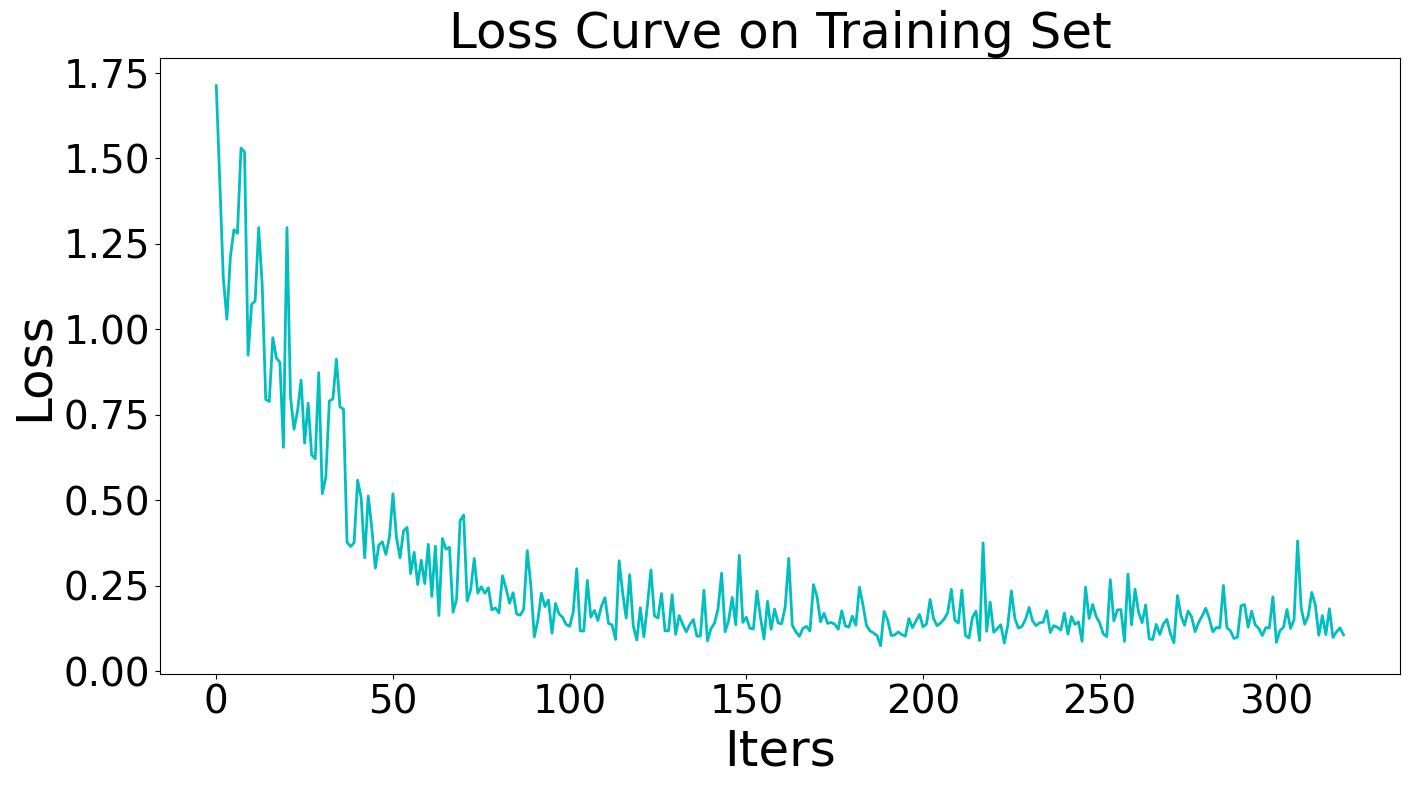

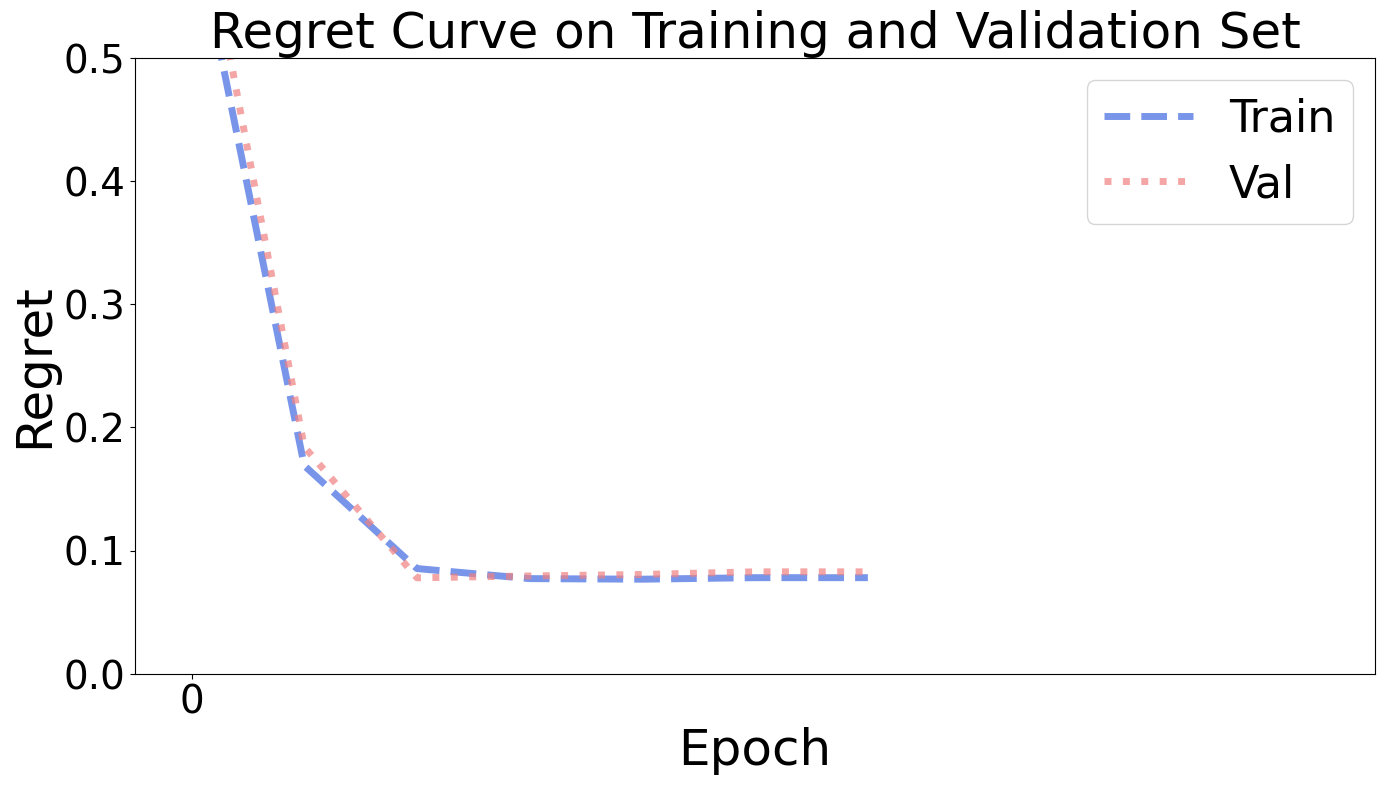

In [15]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Nov 22 01:08:04 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [18]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:02<?, ?it/s]

Epoch   0, Train Regret:  60.1546%, Val Regret:  70.9168%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:17<01:59,  6.62s/it]

Epoch   2, Train Regret:  10.8900%, Val Regret:   9.4629%


Epoch    3, Loss:  -0.9998:  20%|███████████                                            | 4/20 [00:25<01:17,  4.83s/it]

Epoch   4, Train Regret:   9.0737%, Val Regret:  10.3846%


Epoch    5, Loss:  -0.9999:  30%|████████████████▌                                      | 6/20 [00:33<00:59,  4.27s/it]

Epoch   6, Train Regret:   8.6737%, Val Regret:  11.0782%


Epoch    7, Loss:  -1.0000:  40%|██████████████████████                                 | 8/20 [00:42<01:03,  5.26s/it]


Epoch   8, Train Regret:   9.0261%, Val Regret:  10.5995%

Early Stop!
Epoch   8, Train Regret:   9.0261%, Val Regret:  10.5995%

Evaluation:
Test Regret: 9.5475%
Training Elapsed Time: 22.15 Sec


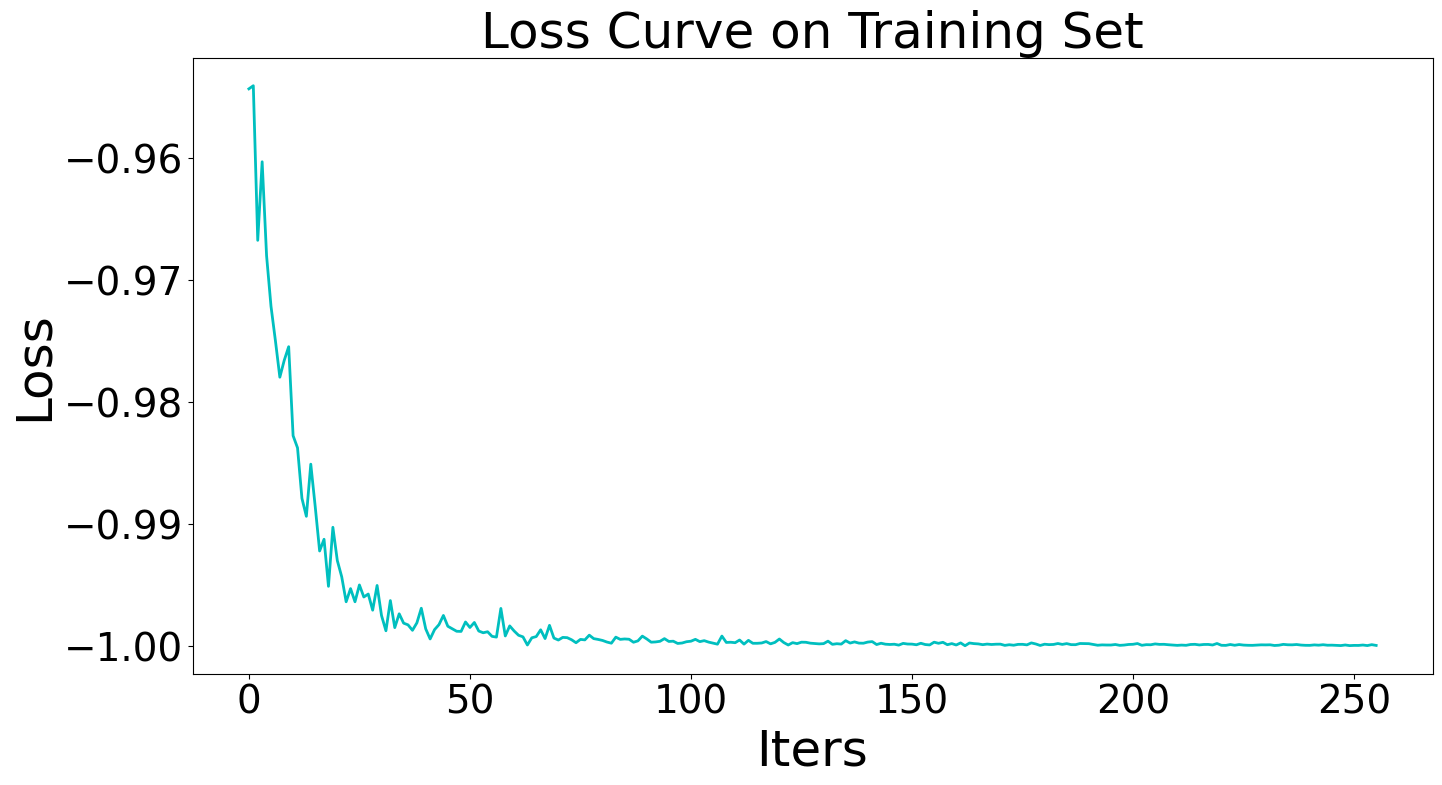

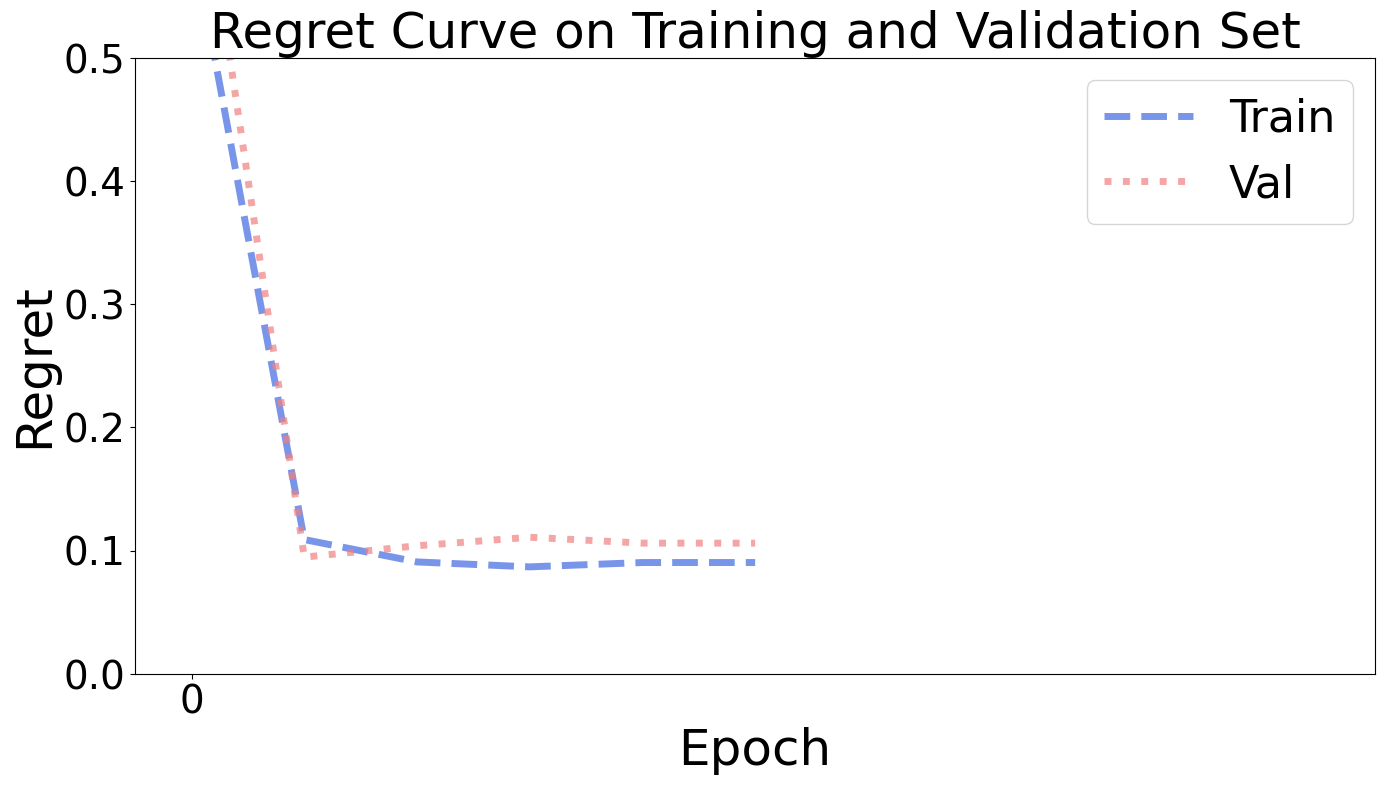

In [19]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=1)

Num of cores: 1


In [22]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:02<?, ?it/s]

Epoch   0, Train Regret:  58.4252%, Val Regret:  61.1047%


Epoch    1, Loss:  -0.9999:  10%|█████▌                                                 | 2/20 [00:07<00:44,  2.47s/it]

Epoch   2, Train Regret:  10.2117%, Val Regret:  12.4198%


Epoch    3, Loss:  -0.9996:  20%|███████████                                            | 4/20 [00:12<00:38,  2.38s/it]

Epoch   4, Train Regret:   8.6946%, Val Regret:   9.9772%


Epoch    5, Loss:  -0.9998:  30%|████████████████▌                                      | 6/20 [00:17<00:33,  2.38s/it]

Epoch   6, Train Regret:   8.3628%, Val Regret:   9.9733%


Epoch    7, Loss:  -0.9999:  40%|██████████████████████                                 | 8/20 [00:22<00:28,  2.37s/it]

Epoch   8, Train Regret:   8.7823%, Val Regret:  10.2417%


Epoch    9, Loss:  -1.0000:  50%|███████████████████████████                           | 10/20 [00:27<00:27,  2.79s/it]


Epoch  10, Train Regret:   9.6054%, Val Regret:  11.2800%

Early Stop!
Epoch  10, Train Regret:   9.6054%, Val Regret:  11.2800%

Evaluation:
Test Regret: 9.7412%
Training Elapsed Time: 4.30 Sec


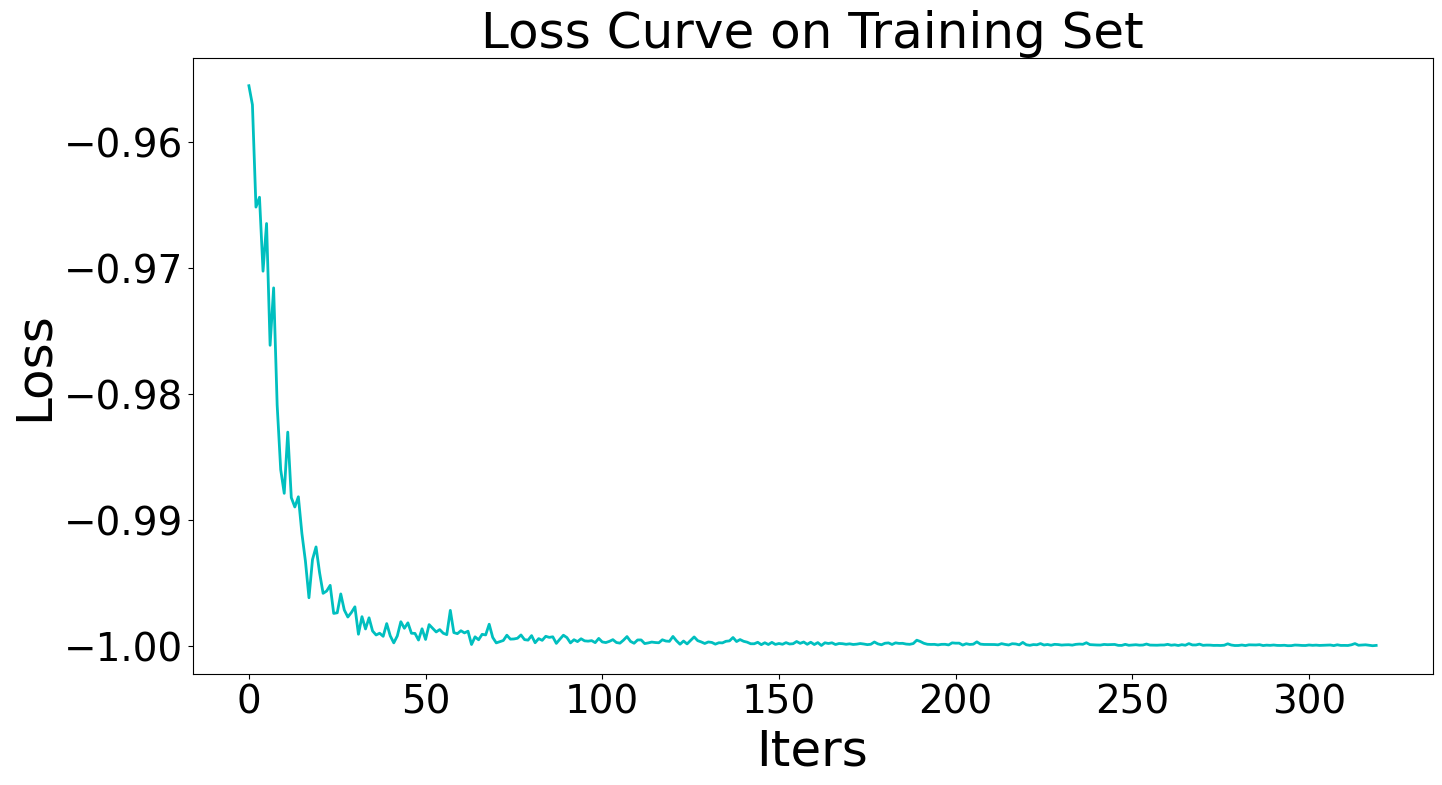

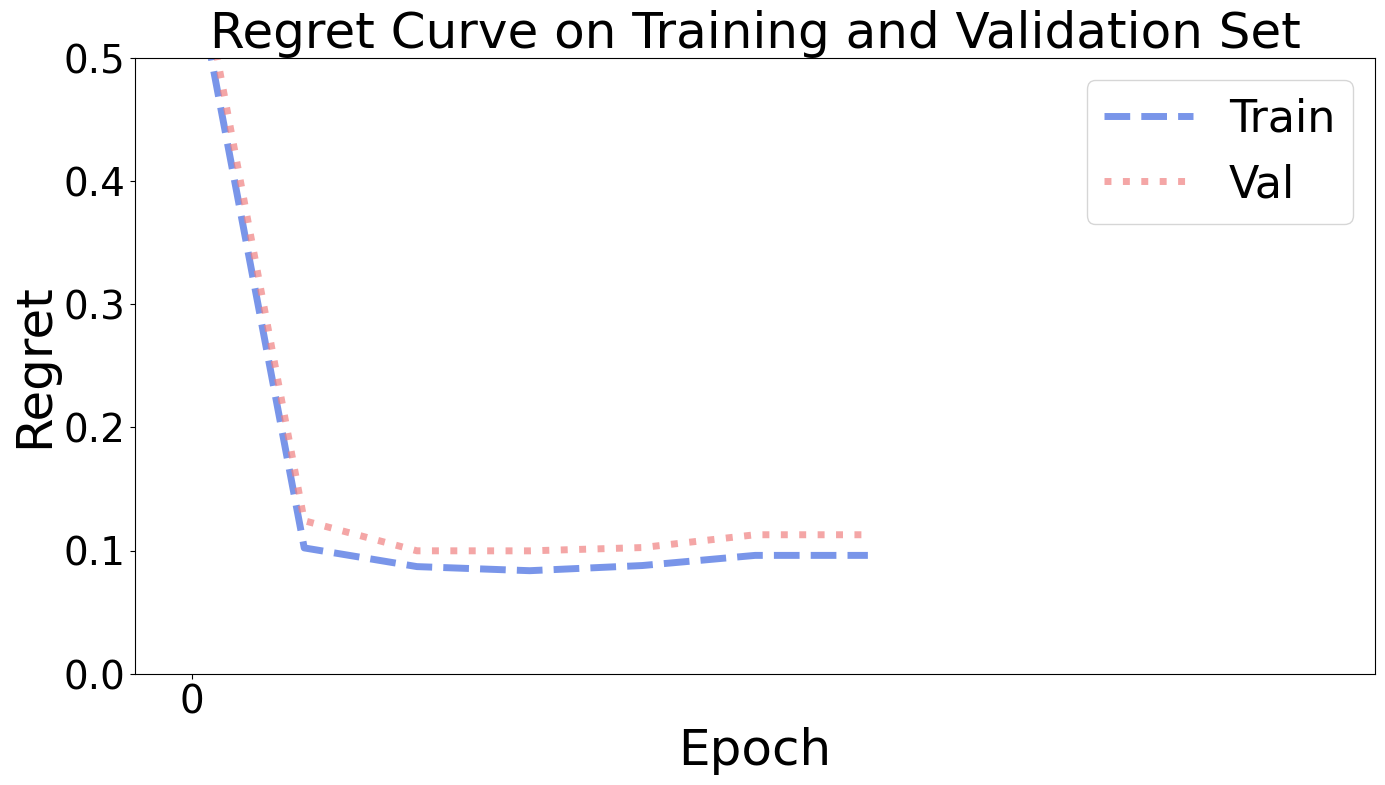

In [23]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:02<?, ?it/s]

Epoch   0, Train Regret:  60.1546%, Val Regret:  70.9168%


Epoch    1, Loss:  -0.6671:  10%|█████▌                                                 | 2/20 [00:07<00:40,  2.25s/it]

Epoch   2, Train Regret:   9.1369%, Val Regret:   9.9882%


Epoch    3, Loss:  -0.6647:  20%|███████████                                            | 4/20 [00:11<00:35,  2.23s/it]

Epoch   4, Train Regret:   8.9957%, Val Regret:  10.5568%


Epoch    5, Loss:  -0.6710:  30%|████████████████▌                                      | 6/20 [00:16<00:31,  2.25s/it]

Epoch   6, Train Regret:   8.6524%, Val Regret:  10.7053%


Epoch    7, Loss:  -0.6513:  40%|██████████████████████                                 | 8/20 [00:21<00:32,  2.74s/it]


Epoch   8, Train Regret:   9.4530%, Val Regret:  11.2727%

Early Stop!
Epoch   8, Train Regret:   9.4530%, Val Regret:  11.2727%

Evaluation:
Test Regret: 9.5627%
Training Elapsed Time: 2.70 Sec


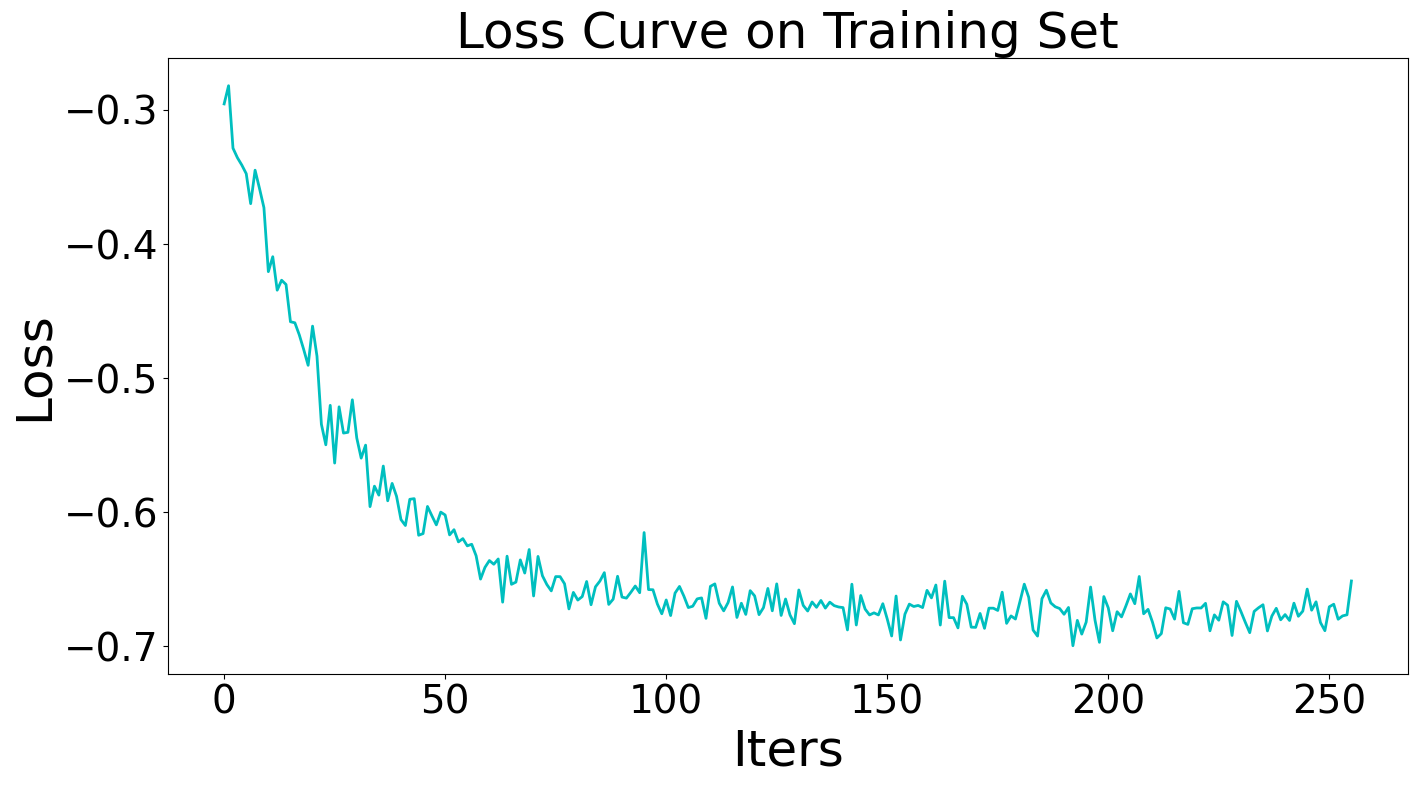

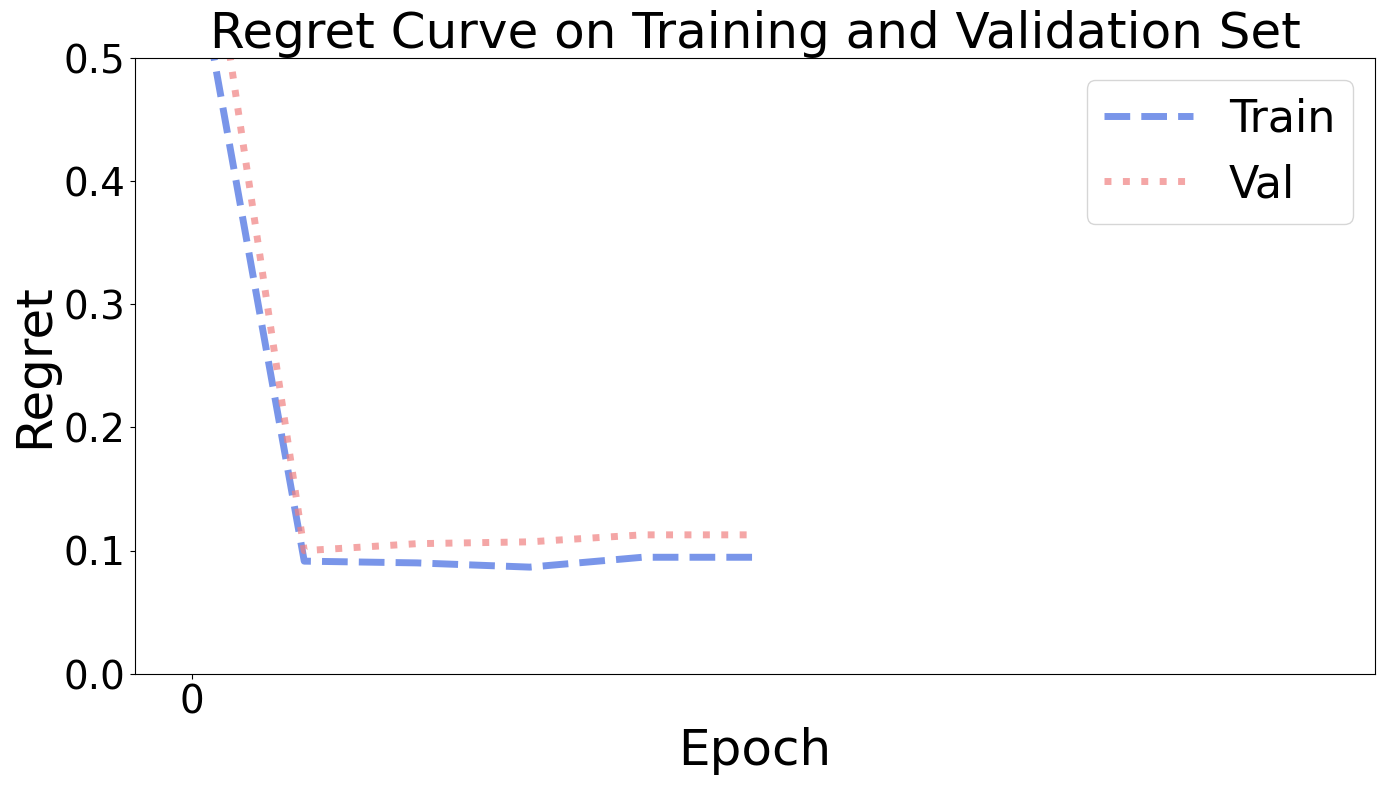

In [27]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [30]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:02<?, ?it/s]

Epoch   0, Train Regret:  58.4252%, Val Regret:  61.1047%


Epoch    1, Loss:  -0.7276:  10%|█████▌                                                 | 2/20 [00:06<00:36,  2.01s/it]

Epoch   2, Train Regret:  12.7172%, Val Regret:  13.6782%


Epoch    3, Loss:  -0.7381:  20%|███████████                                            | 4/20 [00:11<00:32,  2.03s/it]

Epoch   4, Train Regret:   8.4646%, Val Regret:  10.3651%


Epoch    5, Loss:  -0.7693:  30%|████████████████▌                                      | 6/20 [00:15<00:28,  2.03s/it]

Epoch   6, Train Regret:   8.5381%, Val Regret:  10.8912%


Epoch    7, Loss:  -0.7161:  40%|██████████████████████                                 | 8/20 [00:19<00:24,  2.03s/it]

Epoch   8, Train Regret:   8.7586%, Val Regret:  11.1898%


Epoch    9, Loss:  -0.7817:  50%|███████████████████████████                           | 10/20 [00:24<00:24,  2.43s/it]


Epoch  10, Train Regret:   8.5865%, Val Regret:  11.2028%

Early Stop!
Epoch  10, Train Regret:   8.5865%, Val Regret:  11.2028%

Evaluation:
Test Regret: 9.2980%
Training Elapsed Time: 1.14 Sec


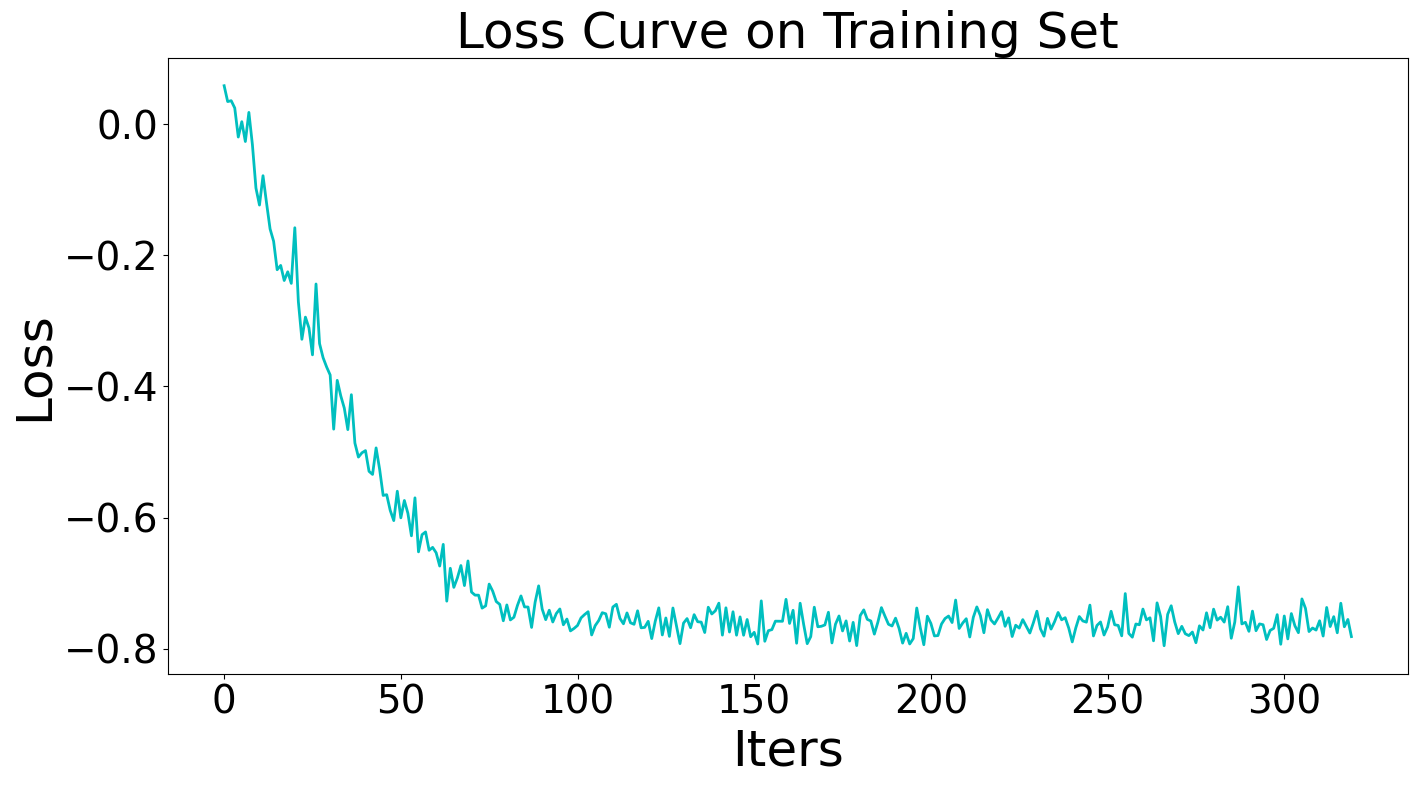

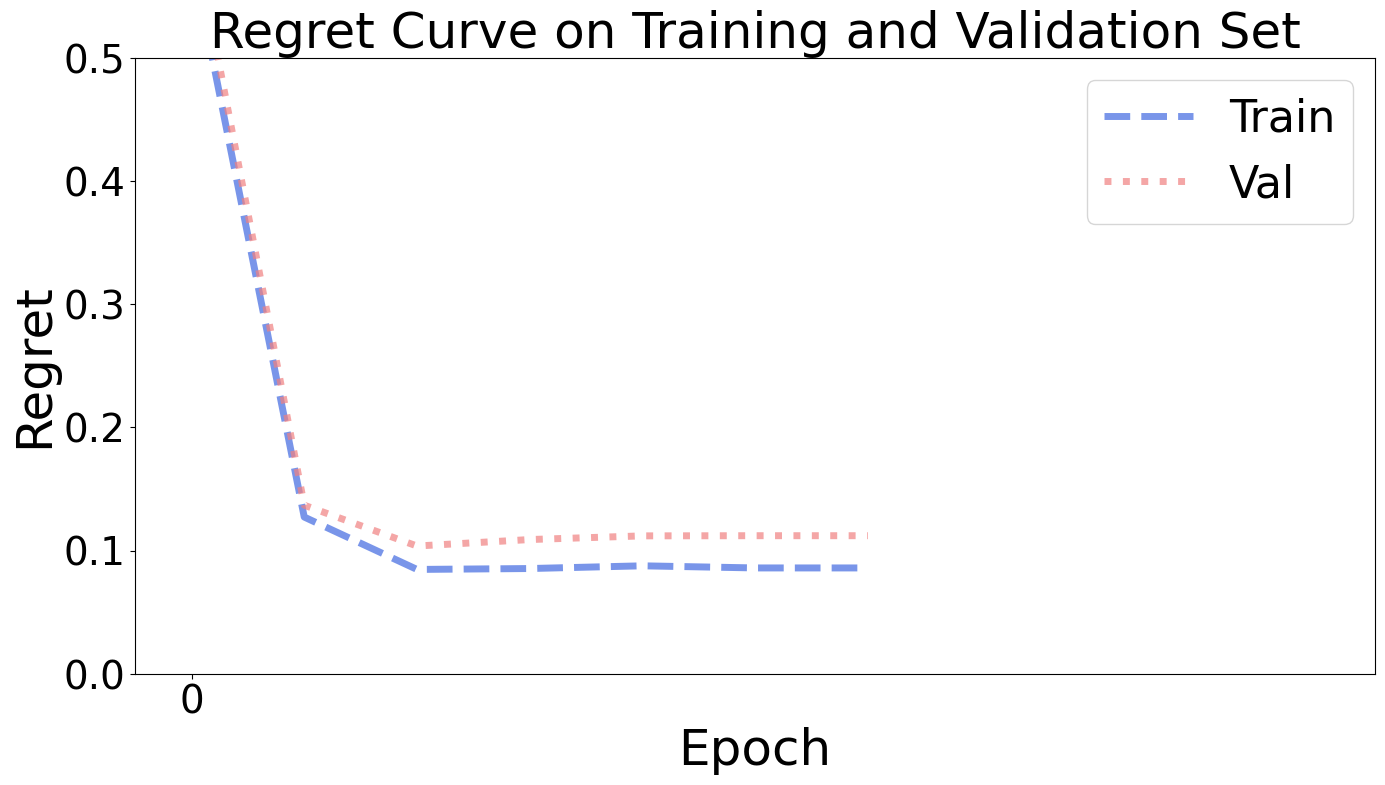

In [31]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func):
    # unzip data
    x, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [34]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:02<?, ?it/s]

Epoch   0, Train Regret:  60.1546%, Val Regret:  70.9168%


Epoch    1, Loss:   7.5000:  10%|█████▌                                                 | 2/20 [00:08<00:56,  3.14s/it]

Epoch   2, Train Regret:   8.3621%, Val Regret:   8.4644%


Epoch    3, Loss:   9.7500:  20%|███████████                                            | 4/20 [00:15<00:49,  3.12s/it]

Epoch   4, Train Regret:   7.5641%, Val Regret:   8.2002%


Epoch    5, Loss:   6.7500:  30%|████████████████▌                                      | 6/20 [00:22<00:44,  3.21s/it]

Epoch   6, Train Regret:   6.9649%, Val Regret:   8.7675%


Epoch    7, Loss:   8.5000:  40%|██████████████████████                                 | 8/20 [00:29<00:39,  3.27s/it]

Epoch   8, Train Regret:   7.2633%, Val Regret:   7.6364%


Epoch    9, Loss:   5.0000:  50%|███████████████████████████                           | 10/20 [00:36<00:32,  3.30s/it]

Epoch  10, Train Regret:   7.1965%, Val Regret:   7.7492%


Epoch   11, Loss:   3.7500:  60%|████████████████████████████████▍                     | 12/20 [00:43<00:25,  3.23s/it]

Epoch  12, Train Regret:   7.1165%, Val Regret:   8.1215%


Epoch   13, Loss:   6.2500:  70%|█████████████████████████████████████▊                | 14/20 [00:50<00:19,  3.17s/it]

Epoch  14, Train Regret:   6.8858%, Val Regret:   7.1601%


Epoch   15, Loss:   7.5000:  80%|███████████████████████████████████████████▏          | 16/20 [00:56<00:12,  3.13s/it]

Epoch  16, Train Regret:   6.8652%, Val Regret:   8.6850%


Epoch   17, Loss:   7.5000:  90%|████████████████████████████████████████████████▌     | 18/20 [01:03<00:06,  3.13s/it]

Epoch  18, Train Regret:   6.9950%, Val Regret:   8.2860%


Epoch   19, Loss:   6.0000: 100%|██████████████████████████████████████████████████████| 20/20 [01:08<00:00,  3.40s/it]


Epoch  19, Train Regret:   7.0380%, Val Regret:   7.1032%

Evaluation:
Test Regret: 7.3267%
Training Elapsed Time: 24.61 Sec


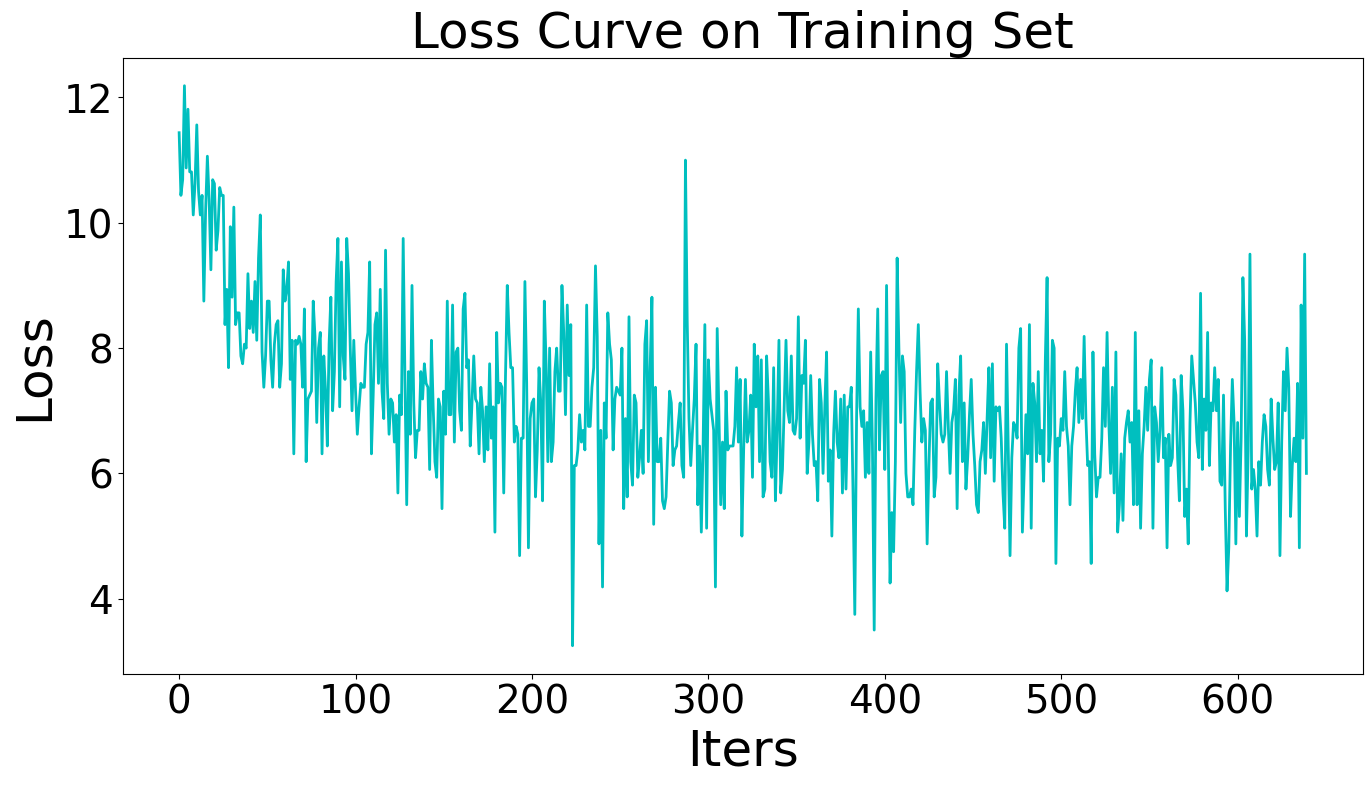

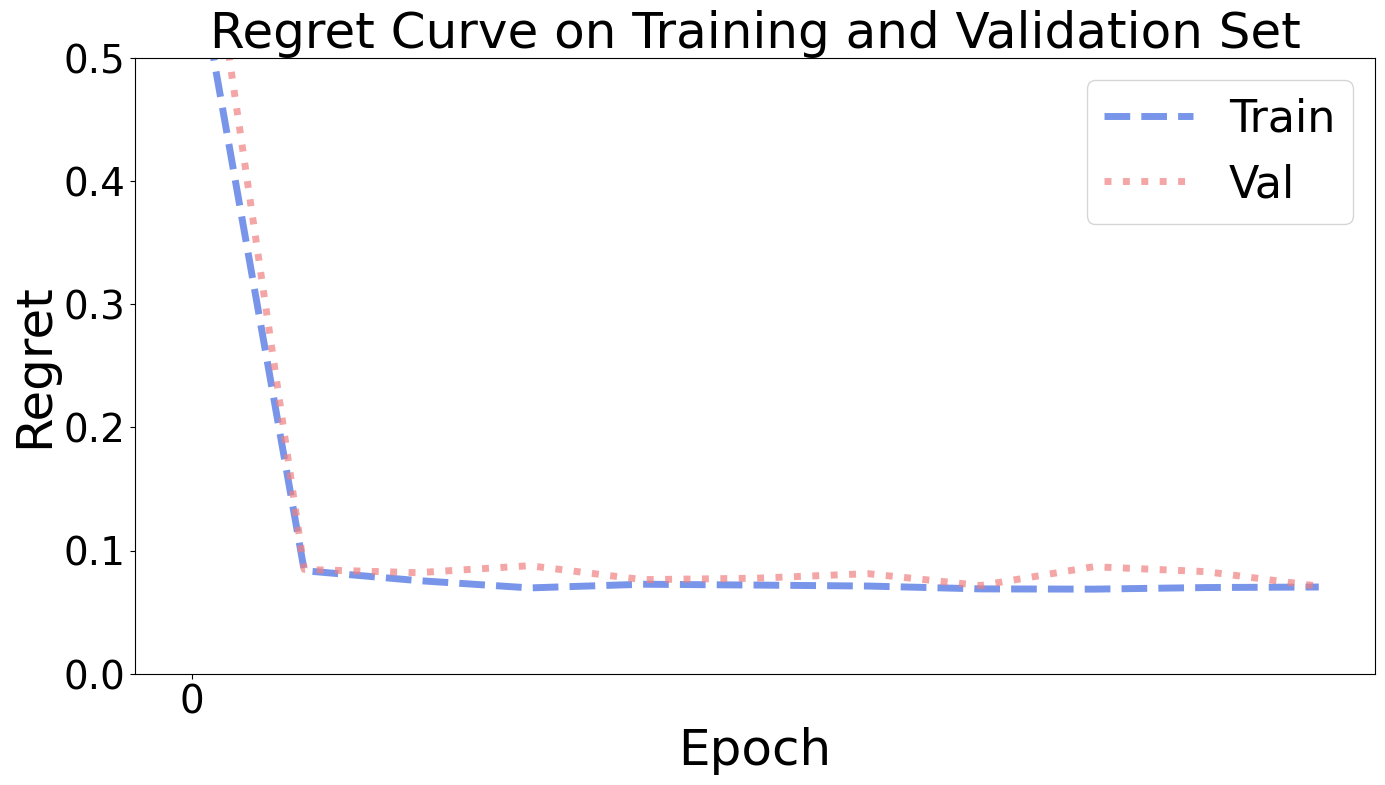

In [35]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func):
    # unzip data
    x, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:02<?, ?it/s]

Epoch   0, Train Regret:  53.2812%, Val Regret:  52.3336%


Epoch    1, Loss:  -7.4996:  10%|█████▌                                                 | 2/20 [00:06<00:37,  2.07s/it]

Epoch   2, Train Regret:  12.7342%, Val Regret:  14.9240%


Epoch    3, Loss: -15.0836:  20%|███████████                                            | 4/20 [00:11<00:32,  2.04s/it]

Epoch   4, Train Regret:  10.6863%, Val Regret:  10.2055%


Epoch    5, Loss: -22.8813:  30%|████████████████▌                                      | 6/20 [00:15<00:28,  2.05s/it]

Epoch   6, Train Regret:  10.2992%, Val Regret:   8.6725%


Epoch    7, Loss: -23.5505:  40%|██████████████████████                                 | 8/20 [00:20<00:24,  2.06s/it]

Epoch   8, Train Regret:  10.2155%, Val Regret:   8.8072%


Epoch    9, Loss: -40.0087:  50%|███████████████████████████                           | 10/20 [00:24<00:21,  2.10s/it]

Epoch  10, Train Regret:  10.1437%, Val Regret:   8.7565%


Epoch   11, Loss: -46.9641:  60%|████████████████████████████████▍                     | 12/20 [00:29<00:19,  2.47s/it]


Epoch  12, Train Regret:  10.1511%, Val Regret:   8.9323%

Early Stop!
Epoch  12, Train Regret:  10.1511%, Val Regret:   8.9323%

Evaluation:
Test Regret: 11.1199%
Training Elapsed Time: 2.23 Sec


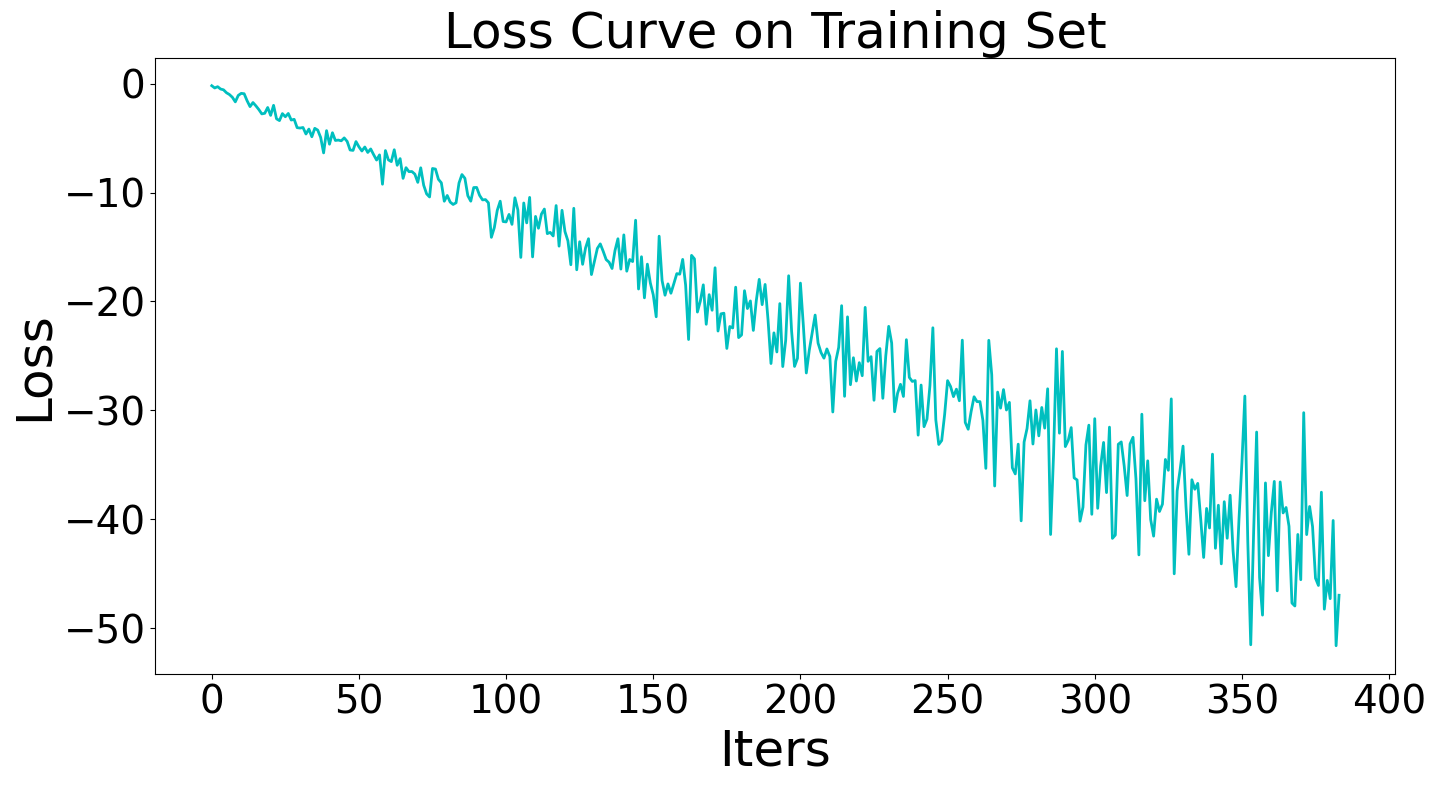

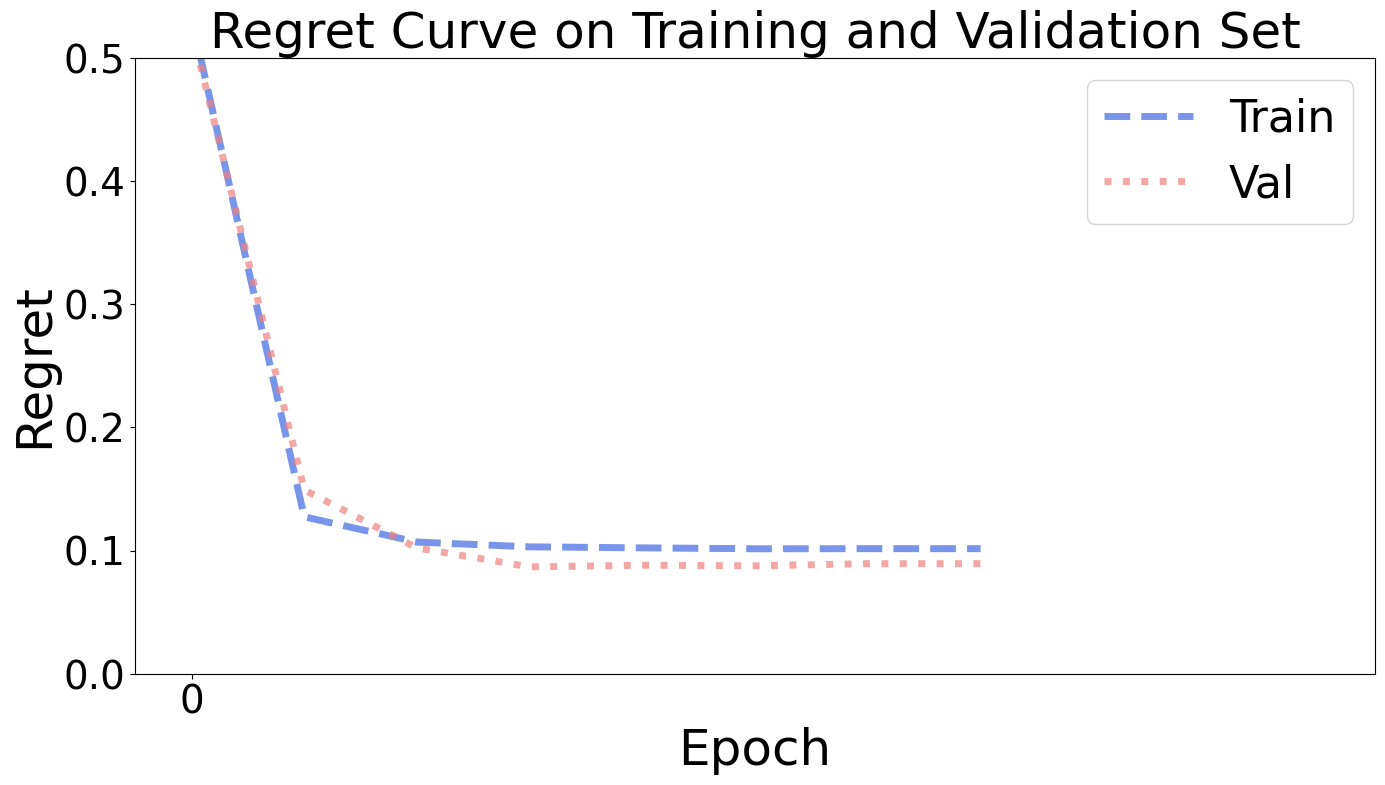

In [39]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)